In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


# from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir = "C:/Users/abini/Downloads/arch-20230623T040111Z-001/arch/train"
test_dir = "C:/Users/abini/Downloads/arch-20230623T040111Z-001/arch/test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64      #Was 46
EPOCHS = 1
LR =  0.1
NUM_CLASSES = 14
CLASS_LABELS = ['gargoyle','dome(outer)','flying_buttress','altar','dome(inner)','bell_tower','vault','stained_glass','column','apse']

In [7]:
preprocess_fun = tf.keras.applications.resnet.preprocess_input

train_datagen = ImageDataGenerator(
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split=0.2, # set validation split, Added
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_fun
                                 )

In [8]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                     subset='training',    #Added
                                                    seed = SEED
                                                   )

validation_generator = train_datagen.flow_from_directory(train_dir, # same directory as training data
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset='validation', # set as validation data,  #Added
                                                    seed = SEED
                                                   )





test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                  )

Found 7954 images belonging to 10 classes.
Found 1984 images belonging to 10 classes.
Found 1376 images belonging to 10 classes.


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="weights-improvementresnet15v2-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [10]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.ResNet152V2(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)

    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4) (x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)

    return x

def final_model(inputs):
    resnet15v2_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(resnet15v2_feature_extractor)

    return classification_output

def define_compile_model():

    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)

    model.compile(optimizer=tf.keras.optimizers.SGD(LR),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
    return model

model = define_compile_model()
# clear_output()
model.summary()

234545216/234545216 [==============================] - 153s 1us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 resnet152v2 (Functional)    (None, 2, 2, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                          

In [18]:
history = model.fit(x = train_generator,validation_data=validation_generator,epochs = 100,callbacks=callbacks_list)

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 2.9425 - accuracy: 0.1344
Epoch 1: val_accuracy improved from -inf to 0.15726, saving model to weights-improvementresnet15v2-01-0.16.hdf5
125/125 [==============================] - 610s 5s/step - loss: 2.9425 - accuracy: 0.1344 - val_loss: 35111200.0000 - val_accuracy: 0.1573
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 2.7506 - accuracy: 0.1461
Epoch 2: val_accuracy did not improve from 0.15726
125/125 [==============================] - 643s 5s/step - loss: 2.7506 - accuracy: 0.1461 - val_loss: 20338.8691 - val_accuracy: 0.1300
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 2.7813 - accuracy: 0.1476
Epoch 3: val_accuracy improved from 0.15726 to 0.18750, saving model to weights-improvementresnet15v2-03-0.19.hdf5
125/125 [==============================] - 673s 5s/step - loss: 2.7813 - accuracy: 0.1476 - val_loss: 63.3665 - val_accuracy: 0.1875
Epoch 4/100
125/125 [==

22/22 [==============================] - 21s 849ms/step
ROC AUC score: 0.8412814230007963


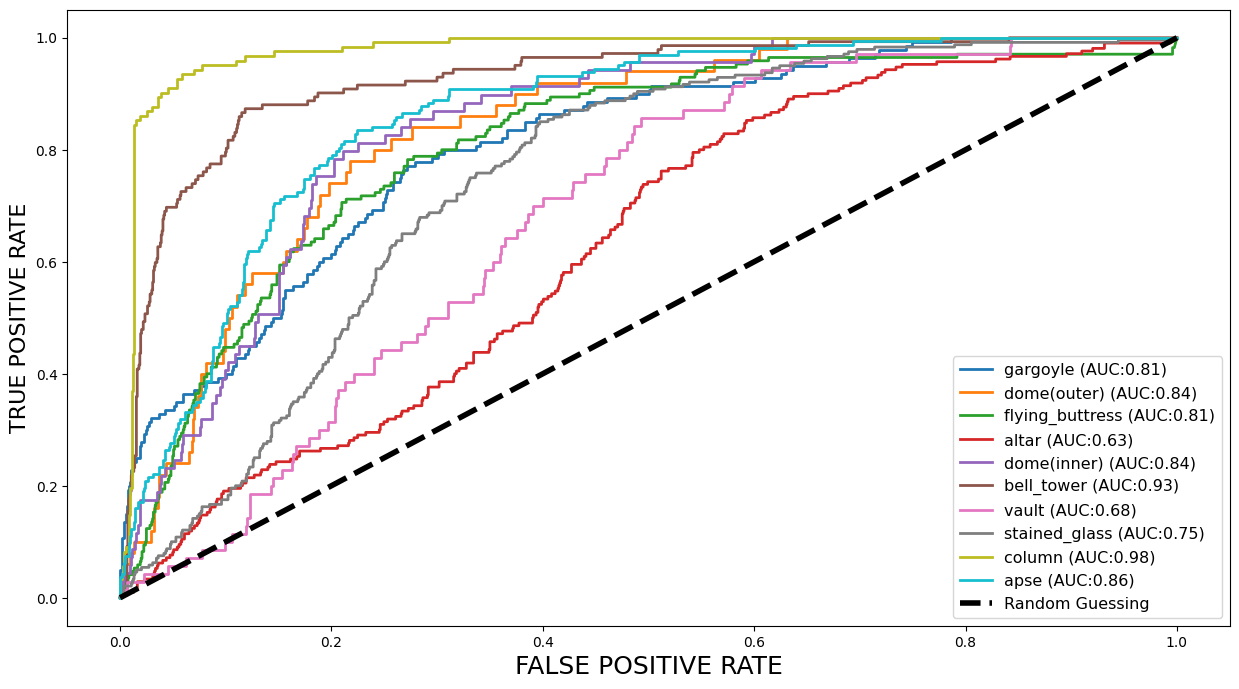

In [23]:
preds = model.predict(test_generator)
y_test = test_generator.classes
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test,preds, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int),preds[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, preds, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [24]:
def plot_metric(model_fit, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_fit.history[metric_name_1]
    metric_value_2 = model_fit.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

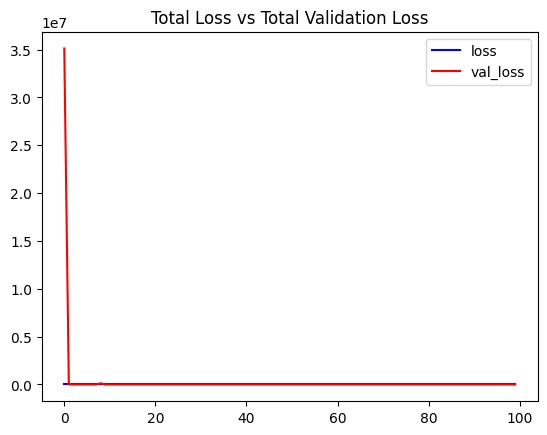

In [25]:
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

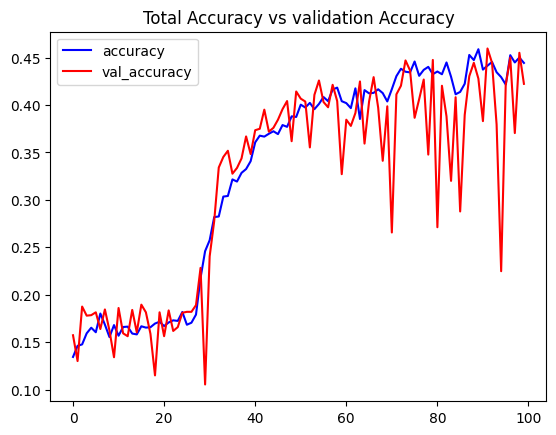

In [26]:
plot_metric(history, 'accuracy', 'val_accuracy', 'Total Accuracy vs validation Accuracy')

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

In [28]:
y_true = np.argmax(preds, axis=1)

In [29]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : altar
1 : apse
2 : bell_tower
3 : column
4 : dome(inner)
5 : dome(outer)
6 : flying_buttress
7 : gargoyle
8 : stained_glass
9 : vault


In [30]:
accuracy = accuracy_score(y_true, y_test)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_test,average="macro")
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_test,average="macro")
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_test,average="macro")
print('F1 score: %f' % f1)
cf_mtx = confusion_matrix(y_true,y_test)
print('Confusion matrix: %f' % cf_mtx)


Accuracy: 0.361919
Precision: 0.309446
Recall: 0.323341
F1 score: 0.296246


TypeError: only size-1 arrays can be converted to Python scalars

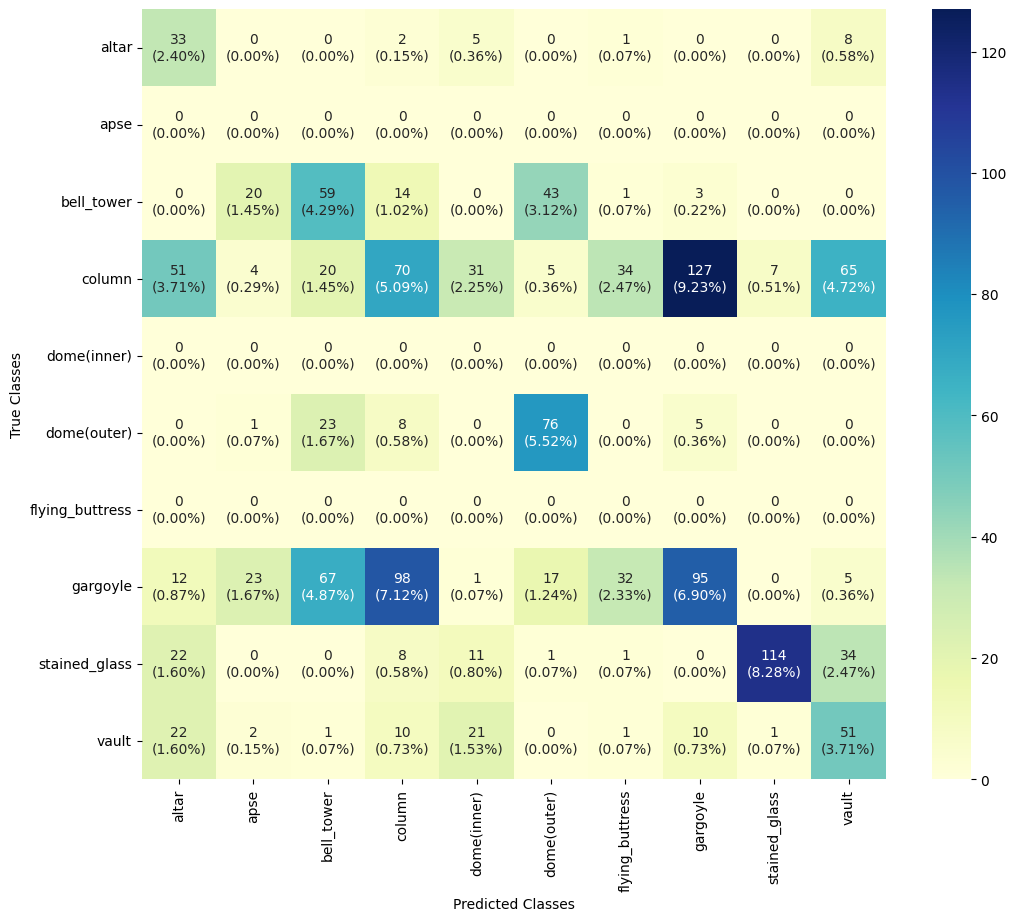

In [31]:
cf_mtx = confusion_matrix(y_true,y_test)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(10, 10)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()